### Convolutional Neural Network

#### explore data

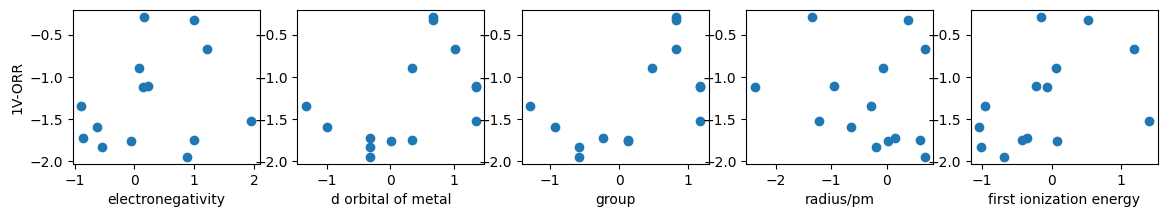

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 
X = pd.read_csv("./data/dataTrain.csv", header=0, usecols=['electronegativity', 'd orbital of metal', 'group', 'radius/pm', 'first ionization energy'])
y = pd.read_csv("./Data/dataTrain.csv", header=0, usecols= ['2V-OER'])


#print(X['electronegativity'])
#print(y['2V-OER'])
plt.figure(figsize=(14, 2))
plt.subplot(1, 5, 1)
plt.scatter(X['electronegativity'], y['2V-OER'])
plt.xlabel('electronegativity')
plt.ylabel('1V-ORR')

plt.subplot(1, 5, 2)
plt.scatter(X['d orbital of metal'], y['2V-OER'])
plt.xlabel('d orbital of metal')

plt.subplot(1, 5, 3)
plt.scatter(X['group'], y['2V-OER'])
plt.xlabel('group')

plt.subplot(1, 5, 4)
plt.scatter(X['radius/pm'], y['2V-OER'])
plt.xlabel('radius/pm')

plt.subplot(1, 5, 5)
plt.scatter(X['first ionization energy'], y['2V-OER'])
plt.xlabel('first ionization energy')

plt.show()

#### Prepare data for Pytorch

In [2]:
import torch
import torch.utils.data as td
from sklearn.model_selection import train_test_split
import pandas as pd

def loaddata(pathway, Ylabel, i, j, k):
    df = pd.read_csv(pathway)
    Xfeatures = ['electronegativity', 'd orbital of metal', 'group', 'radius/pm', 'first ionization energy']
    x = df[Xfeatures].values
    y = df[Ylabel].values

    label0, label1, label2 = x[i], x[j], x[k]
    label0, label1, label2 = torch.Tensor(label0).float(), torch.Tensor(label1).float(), torch.Tensor(label2).float()
    label0 = label0.reshape(1, 1, 5).float()
    label1 = label1.reshape(1, 1, 5).float()
    label2 = label2.reshape(1, 1, 5).float()
    
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)
    
    # create loader for the training data and labels
    train_x = torch.Tensor(X_train).float()
    train_x = train_x.reshape(12, 1, 5).float()
    train_y = torch.Tensor(y_train).float()
    train_data = td.TensorDataset(train_x, train_y)
    train_loader = td.DataLoader(train_data, batch_size=1, shuffle=False, num_workers=1)

    # create loader for the test data and labels
    test_x = torch.Tensor(X_test).float()
    test_x = test_x.reshape(2, 1, 5).float()
    test_y = torch.Tensor(y_test).float()
    test_data = td.TensorDataset(test_x, test_y)
    test_loader = td.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=1)

    return train_loader, test_loader, label0, label1, label2

pathway = "./Data/dataTrain.csv"
Ylabel = "2V-OER"
train_loader, test_loader, label0, label1, label2 = loaddata(pathway, Ylabel, 1, 2, 3)


#### Define the CNN

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Conv1d_same_padding(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, strides=1, dilation=1):
        super(Conv1d_same_padding, self).__init__()
        self.kernel_size = kernel_size
        self.strides = strides
        self.dilation = dilation
        self.conv1d = nn.Conv1d(inplanes, planes, kernel_size, strides, bias=False)
        nn.init.xavier_uniform_(self.conv1d.weight)

    def forward(self, x):
        input_rows = x.size(2)
        out_rows = (input_rows + self.strides -1) // self.strides
        padding_rows = max(0, (out_rows - 1) * self.strides + (self.kernel_size - 1) * self.dilation + 1 - input_rows)
        x = F.pad(x, pad=(0, padding_rows), mode="constant")
        x = self.conv1d(x)
        return x

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()

        self.conv0 = Conv1d_same_padding(4, 16, 1)
        self.conv1 = Conv1d_same_padding(16, 16, 1)
        self.conv2 = Conv1d_same_padding(16, 16, 1)
        self.conv3 = Conv1d_same_padding(16, 16, 1)
        self.conv4 = Conv1d_same_padding(16, 8, 1)

        self.dense0 = nn.Linear(40, 32, bias=False)
        self.dense1 = nn.Linear(32, 16, bias=False)
        self.dense2 = nn.Linear(16, 1, bias=False)

        nn.init.xavier_uniform_(self.dense0.weight)
        nn.init.xavier_uniform_(self.dense1.weight)
        nn.init.xavier_uniform_(self.dense2.weight)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = torch.flatten(x)
        
        x = F.relu(self.dense0(x))
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

model = CNNNet()
print(model)

CNNNet(
  (conv0): Conv1d_same_padding(
    (conv1d): Conv1d(4, 16, kernel_size=(1,), stride=(1,), bias=False)
  )
  (conv1): Conv1d_same_padding(
    (conv1d): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
  )
  (conv2): Conv1d_same_padding(
    (conv1d): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
  )
  (conv3): Conv1d_same_padding(
    (conv1d): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
  )
  (conv4): Conv1d_same_padding(
    (conv1d): Conv1d(16, 8, kernel_size=(1,), stride=(1,), bias=False)
  )
  (dense0): Linear(in_features=40, out_features=32, bias=False)
  (dense1): Linear(in_features=32, out_features=16, bias=False)
  (dense2): Linear(in_features=16, out_features=1, bias=False)
)


#### Train the model

In [4]:
 
def train(model, train_loader, optimizer, label0, label1, label2):
    # set the model to train the model
    model.train()
    train_loss, train_error = 0, 0
    
    index = 0
    for datax, target in train_loader:
        
        data = torch.cat([datax, label0, label1, label2], dim=1)
        # feed forward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        error = error_criteria(out, target)
        #print(loss)

        # backpropagate 
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_error += error.item()
        index += 1

    avg_loss, avg_error = (train_loss / index), (train_error / index)
    print("Training set: Average loss: {:.6f}, error: {:.6f}".format(avg_loss, avg_error))
    return avg_loss, avg_error
    
def test(model, test_loader, label0, label1, label2):
    # set the model to evaluation mode
    model.eval()
    test_loss, test_error = 0, 0
    
    with torch.no_grad():
        index = 0
        for datax, target in test_loader:
            
            data = torch.cat([datax, label0, label1, label2], dim=1)
            out = model(data)
            
            test_loss += loss_criteria(out, target).item()
            test_error += error_criteria(out, target).item()           
            index += 1

        avg_loss, avg_error = (test_loss / index), (test_error / index)
        print("Test set: Average loss: {:.6f}, error: {:.6f}".format(avg_loss, avg_error))
        return avg_loss, avg_error

In [5]:
import torch.nn as nn

#specify the loss criteria
class MyError(torch.nn.Module): 
    def __init__(self):
        super(MyError, self).__init__() 
        
    def forward(self, pred, real): 
        return torch.mean(torch.abs(torch.sub(pred, real) / real)) 

error_criteria = MyError()
loss_criteria = nn.MSELoss()

pathway = "./Data/dataTrain.csv"
Ylabel = "2V-OER"

# model and datafile
train_loader, test_loader, label0, label1, label2 = loaddata(pathway, Ylabel, 3, 11, 13)
model = CNNNet()

# use an "Adam" optimizer to adjust weights
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
optimizer.zero_grad()

# track metrics
epoch_nums = []
training_loss, training_error = [], []
testing_loss, testing_error = [], []

epochs = 30
for epoch in range(1, epochs+1):
    print("Epoch: {}".format(epoch))
    
    train_loss, train_error = train(model, train_loader, optimizer, label0, label1, label2)
    test_loss, test_error = test(model, test_loader, label0, label1, label2)

    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    training_error.append(train_error)
    
    testing_loss.append(test_loss)
    testing_error.append(test_error)



Epoch: 1
Training set: Average loss: 1.821000, error: 1.038601
Test set: Average loss: 3.196855, error: 1.006033
Epoch: 2
Training set: Average loss: 1.685893, error: 0.977941
Test set: Average loss: 3.048121, error: 0.982948
Epoch: 3
Training set: Average loss: 1.557335, error: 0.901323
Test set: Average loss: 2.760793, error: 0.936192
Epoch: 4
Training set: Average loss: 1.302941, error: 0.724554
Test set: Average loss: 2.119469, error: 0.820192
Epoch: 5
Training set: Average loss: 0.836850, error: 0.747252
Test set: Average loss: 0.996949, error: 0.561694
Epoch: 6
Training set: Average loss: 0.412075, error: 0.755344
Test set: Average loss: 0.186232, error: 0.237510
Epoch: 7
Training set: Average loss: 0.278010, error: 0.754180
Test set: Average loss: 0.164321, error: 0.215887
Epoch: 8
Training set: Average loss: 0.215770, error: 0.621264
Test set: Average loss: 0.191769, error: 0.228364
Epoch: 9
Training set: Average loss: 0.203186, error: 0.597542
Test set: Average loss: 0.125806,

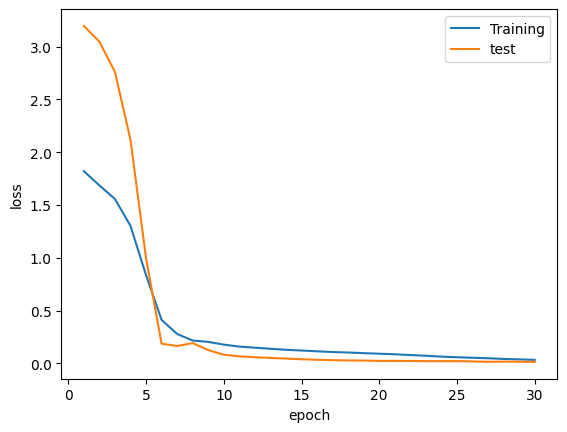

In [6]:
import matplotlib.pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, testing_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'test'], loc='upper right')
plt.show()

#### save the trained model

In [7]:
model_file = "./Models/pred_2VOER.pt"
torch.save(model.state_dict(), model_file)
del model
print("model is saved")

model is saved


#### Use the saved model

##### Load data for prediction

In [8]:
import torch
import torch.utils.data as td
from sklearn.model_selection import train_test_split
import pandas as pd

def loaddata(pathway1, pathway2, i, j, k):
    df1 = pd.read_csv(pathway1)
    df2 = pd.read_csv(pathway2)
    Xfeatures = ['electronegativity', 'd orbital of metal', 'group', 'radius/pm', 'first ionization energy']
    x = df1[Xfeatures].values

    label0, label1, label2 = x[i], x[j], x[k]
    label0, label1, label2 = torch.Tensor(label0).float(), torch.Tensor(label1).float(), torch.Tensor(label2).float()
    label0 = label0.reshape(1, 1, 5).float()
    label1 = label1.reshape(1, 1, 5).float()
    label2 = label2.reshape(1, 1, 5).float()
    
    predict_x = df2[Xfeatures].values
    predict_x = torch.Tensor(predict_x).float()
    #predict_x = predict_x.reshape(15, 1, 5).float()

    return predict_x, label0, label1, label2

pathway1 = "./Data/dataTrain.csv"
pathway2 = "./Data/dataTest.csv"
predict_x, label0, label1, label2 = loaddata(pathway1, pathway2, 3, 11, 13)
print(predict_x.shape)
for data in predict_x:
    pass
print(data.shape)
print(data)

for data in predict_x:
    data = data.reshape(1, 1, 5).float()
    pass
print(data.shape)
print(data)


torch.Size([15, 5])
torch.Size([5])
tensor([-1.7959, -1.6652, -1.6366,  1.1285, -1.0234])
torch.Size([1, 1, 5])
tensor([[[-1.7959, -1.6652, -1.6366,  1.1285, -1.0234]]])


##### predict

In [9]:
def predict(model, predict_data, label0, label1, label2):
    # set the model to evaluation mode
    model.eval()
    predicts = []
    
    with torch.no_grad():  
        for datax in predict_data:
            datax = datax.reshape(1, 1, 5).float()
            data = torch.cat([datax, label0, label1, label2], dim=1)
            out = model(data)
            predicts.append(out.item())
        return predicts

# load data
pathway1 = "./Data/dataTrain.csv"
pathway2 = "./Data/dataTest.csv"
predictx, label0, label1, label2 = loaddata(pathway1, pathway2, 3, 11, 13)

# load model
model = CNNNet() 
model.load_state_dict(torch.load("./Models/pred_2VOER.pt"))

predicts = predict(model, predictx, label0, label1, label2)
#print(predicts)

#### save the results

In [10]:
import numpy as np

np.savetxt("./Results/pred_2VOER.dat", np.array(predicts))